In [1]:
## For debbugging
%load_ext autoreload

In [2]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [3]:
## for debugging:
%aimport mlp.kex
%aimport mlp.tree
%aimport mlp.plot
%autoreload 1
from mlp import kex
from mlp.tree import node_adj_mat, tag_network, tag_df_network
from mlp.plot import hv_net
from bokeh.palettes import Viridis10, Category10_6
import networkx as nx

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline


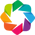

In [5]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=600 height=400]

# Manufacturing Maintenance Case Study

### Import Data

In [6]:
data_dir = module_path/'data'/'gs_data'
df = pd.read_csv(data_dir/'gs_data.csv',
                 dtype={'Part in Process': 'object',
                        'Time Submitted': 'object',
                        'Time Up': 'object'})
# merge and cleanse NLP-containing columns of the data
gs_nlp_select = kex.NLPSelect(columns = ['Description', 'Resolution'])
raw_text = gs_nlp_select.transform(df)

### Build Vocabulary

In [7]:
tex = kex.TokenExtractor()
toks = tex.fit_transform(raw_text)

In [8]:
vocab_fname = data_dir/'vocab.csv' 
vocab = kex.generate_vocabulary_df(tex, init=vocab_fname)

intialized successfully!


### Extract Keywords

In [9]:
# tag_df = tags_to_df(tag_extractor(tex, raw_text, toks, vocab))
tags_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)
tags_read = kex._get_readable_tag_df(tags_df)

intialized successfully!


HBox(children=(IntProgress(value=0, description='Category Loop', max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=146), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=2683), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P token loop', max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S token loop', max=29), HTML(value='')))

HBox(children=(IntProgress(value=0, description='U token loop', max=91), HTML(value='')))

HBox(children=(IntProgress(value=0, description='X token loop', max=4), HTML(value='')))

In [10]:
tags_read.join(df[['Description', 'Resolution']]).head(5)

I       P                  S      U X  \
0                 chain, feeder  broken             repair    bar     
1  machine, cable, pin, pendant   short           replaced  power     
2                          part  broken      repair, order            
3                   accumulator          check, charge, ok            
4    hydraulic, saw, attachment    leak           replaced   seal     

                   Description  \
0      Broken bar feeder chain   
1                     No power   
2    Smartscope harness broken   
3  Check / Charge Accumulators   
4    Hyd leak at saw atachment   

                                          Resolution  
0                                           Repaired  
1  Replaced pin in pendant and powered machine -P...  
2                      Parts ordered / Tech repaired  
3                                           Where OK  
4  Replaced seal in saw attachment but still leak...

In [11]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('tagged tokens: ', vocab[vocab.NE!=''].NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
tagged tokens:  671
total tags:  298


NE  alias  notes  score
NE                         
     1      2      1   2287
I    1    146      8    353
P    1     26      1     77
S    1     29      1    105
U    1     91      7    130
X    1      4      1      4

Tag completeness: 0.66 +/- 0.20
Empty Docs: 15, or 0.44%


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


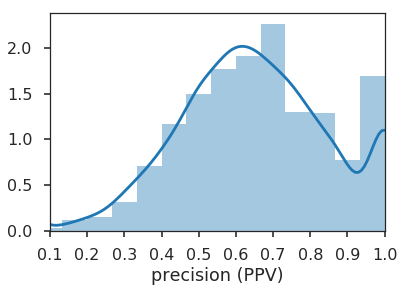

In [149]:
# tag-completeness of work-orders?
tag_comp, tag_empt = kex._get_tag_completeness(tag_df)

with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    sns.distplot(tag_comp.dropna(), bins=15, kde_kws={'cut':0})
    plt.xlim(0.1, 1.0)
    plt.xlabel('precision (PPV)')


In [13]:
# Context expansion, without user-annotation
tex2 = kex.TokenExtractor(ngram_range=(2, 2))  # new extractor (note 2-gram)
replaced_text = kex.token_to_alias(raw_text, vocab)  # raw_text, with token-->alias replacement
toks2 = tex2.fit_transform(replaced_text)

# define rules
NE_map = {'I I': 'I',  # two items makes one new item
          'I P': 'P I', 'I S': 'S I', 'P I': 'P I', 'S I': 'S I',  # order-free 
          'P P': 'X', 'P S': 'X', 'S P': 'X', 'S S': 'X'}  # redundancies
NE_types = 'IPSUX'

#make 2-gram dictionary
vocab2 = kex.ngram_automatch(vocab, kex.generate_vocabulary_df(tex2), NE_types, NE_map)

# extract 2-gram tags from cleaned text
tags2_df = kex.tag_extractor(tex2, replaced_text, vocab_df=vocab2)

intialized successfully!


HBox(children=(IntProgress(value=0, description='Category Loop', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=521), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=3197), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P I token loop', max=426), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S I token loop', max=598), HTML(value='')))

HBox(children=(IntProgress(value=0, description='X token loop', max=258), HTML(value='')))

In [148]:
# merge 1 and 2-grams. 
tag_df = tags_df.join(tags2_df)
tag_readable = kex._get_readable_tag_df(tag_df)
tag_df = tag_df.loc[:,['I', 'P', 'S', 'U', 'X', 'NA']]
tag_readable.head(10)
# pd.merge(tag_df, tags2_df, how='outer')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


I              P  \
0                        chain, feeder, feeder chain         broken   
1  machine, cable, pin, pendant, pendant cable, p...          short   
2                                               part         broken   
3                                        accumulator                  
4         hydraulic, saw, attachment, saw attachment           leak   
5                          unit, thread, thread unit                  
6  unit, saw, gear, attachment, person, shelf, sa...                  
7                                        accumulator                  
8                             station, spindle, mill                  
9                    hydraulic, line, hydraulic line  leak, rupture   

                                 P I                          S  \
0                                                        repair   
1                                                      replaced   
2                                                 repair, order   
3                                             check, charge, ok   
4           hydraulic leak, leak saw                   replaced   
5                                               complete, setup   
6                                     replaced, remove, rebuild   
7                                                 check, charge   
8                                                        repair   
9  hydraulic leak, rupture hydraulic                   replaced   

                                                 S I       U  \
0                                       chain repair     bar   
1                                       replaced pin   power   
2                                                              
3                 charge accumulator, accumulator ok           
4                                attachment replaced    seal   
5                                                     change   
6  unit remove, rebuild unit, replaced saw, perso...           
7              accumulator check, charge accumulator           
8                                                         14   
9                                                              

                                 X  
0                                   
1                                   
2                                   
3                     check charge  
4                                   
5                                   
6                                   
7                     check charge  
8                    repair repair  
9  leak replaced, replaced rupture

## Measuring Machine Performance

In [22]:
colors = {
            'P':'#C0504D',
            'S':'#7ABC32',
            'I':'#4F81BD',
            'U':'#ffc000',
            'NA':'gray',
            'X':'black'
        }

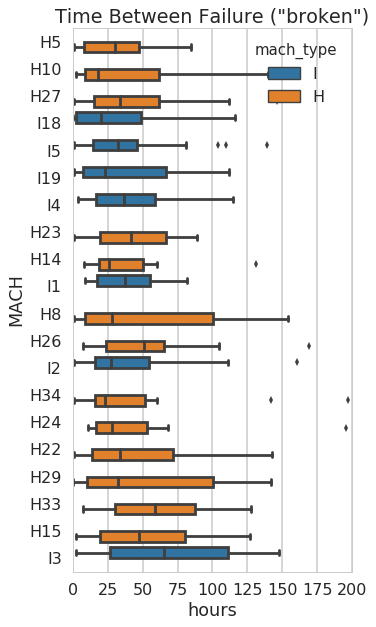

In [27]:
# samp = ['broken', 'motor' ]
h_or_i = df.MACH.str.match(r'^[HI][0-9]*$').fillna(False)
is_broke = (tag_df.P['broken']>0)
df.MACH[h_or_i]
cond = h_or_i & is_broke

idx_col = pd.DatetimeIndex(df['DATE RECEIVED'])
# cond = (tag_df.P['broken']>0)#|(tag_df.S['replace']>0)
sample_tag = tag_df.loc[cond,tag_df.loc[cond].sum()>1]

sample_tag.columns = sample_tag.columns.droplevel(0)

sample_tag = pd.concat([sample_tag, df.MACH[cond]], axis=1)
sample_tag['date'] = idx_col[cond]
sample_tag.loc[:,'mach_type'] = sample_tag.MACH.str[0]#.astype('category')
sample_tag['tbf'] = sample_tag.sort_values(['MACH','date']).groupby('MACH')['date'].diff()

sample_tag.loc[:,'tbf'] = sample_tag.tbf.dt.total_seconds() / (24 * 60 * 60)
(sample_tag.groupby('MACH')['tbf'].sum()/sample_tag.groupby('MACH')['tbf'].count()).sort_values()
sample_tag.mach_type.value_counts()
# sns.boxplot(y='tbf', x='MACH', data=sample_tag.dropna().reset_index())

# sample_tag.dropna(subset=['tbf']).plot(y='tbf', x='MACH', kind='box')
plt.figure(figsize=(5,10))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# sns.violinplot(data=sample_tag[['mach_type', 'tbf', 'MACH']].dropna(), 
#                y='MACH', x='tbf', hue='mach_type', cut=0, orient='h', scale='count', bw=.4)
samps = sample_tag[['mach_type', 'tbf', 'MACH']].dropna()
# order = samps.groupby('MACH').mean().sort_values('tbf').index
order = samps.MACH.value_counts().index
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    sns.boxplot(data=samps, y='MACH', x='tbf', hue='mach_type', orient='h', order=order[:20], notch=False)
    plt.xlabel('hours');
    plt.xlim(0,200)
    plt.title('Time Between Failure ("broken")')
# sns.swarmplot(data=sample_tag.dropna().reset_index(), x='MACH', y='tbf')
# sample_tag.plot()
# samp_g = sample_tag.groupby('MACH')
# shift_g = sample_tag.shift(1)
# samp_g['date']
# samp_g['date']#.transform(pd.Series.diff)
# sample_tag['date'] - sample_tag['date'].shift(1)

### Failure Inter-arrival Times, by Machine


Ordered by total occurences (i.e. "distribution certainty")

- Time between occurences of `broken` tag.
- low $\rightarrow$ bad
- e.g. `H34`, `I19`, and `H14` all seem rather low

What could be the central problems with these machines?

### Top Tag occurences, by Machine

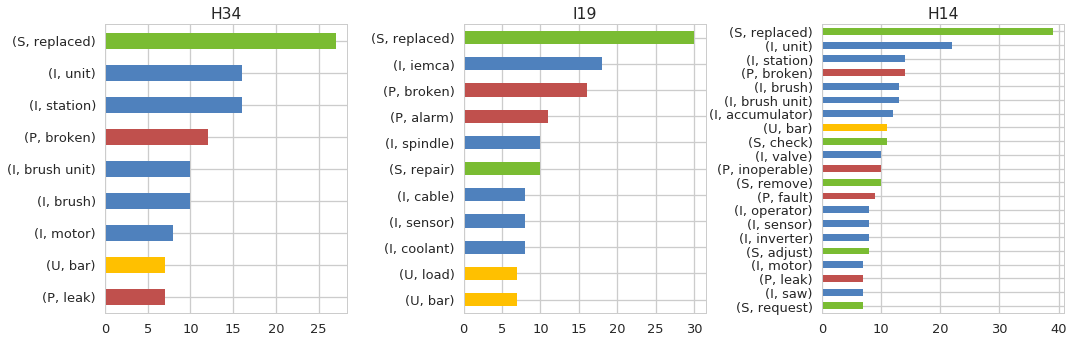

In [76]:
# top3 = sample_tag.MACH.isin(['H34', 'I19', 'H14'])
# sample_tag[top3, sample_tag.loc[top3,:].sum()>3].groupby('MACH').sum().plot(kind='bar')
# tag_df[sample_tag.MACH=='H34'].sum()

def machine_tags(name, n_reps):
    isguy = df['MACH'].str.contains(name, case =False).fillna(False)
    return tag_df.loc[isguy,(tag_df.loc[isguy,:].sum()>n_reps).values]
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('talk') as context:
    f, ax = plt.subplots(ncols=3, figsize=(15, 5))

    for n, mach in enumerate(['H34', 'I19', 'H14']):
        mach_df = machine_tags(mach,  6).sum().sort_values()
        mach_df.plot(kind='barh', color=[colors[i] for i in mach_df.index.get_level_values(0)], ax=ax[n])
        ax[n].set_title(mach)
    plt.tight_layout()

- `H34` issues with `motor`, `unit`, `brush`
- `I19` `alarm`s and/or `sensors`, potentially coolant-related
- `H14` wide array of issues, including `operator` (!?)

Index(['motor', 'brush unit'], dtype='object')


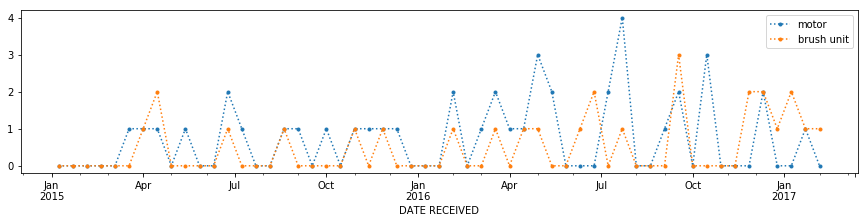

In [78]:
# wo_num = 0
# sample_tag = tag_df.loc[:,tag_df.loc[wo_num].astype(bool)]
is_broke = (tag_df.P['broken']>0)
samp = ['brush unit', 'motor']
sample_tag = tag_df.loc[is_broke,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

# sample_tag = tag_df[['chain', 'bar', 'accumulator']]
sample_tag = sample_tag.set_index(pd.DatetimeIndex(df['DATE RECEIVED'][is_broke]))
# .rolling(1000).sum()
# plt.figure()
sample_tag.resample('2W').sum().plot(figsize=(15,3), marker='.', ls=':')
# df.resample()
print(sample_tag.columns)

## Measuring Technician Performance

In [79]:
islyle = df['Tech Full Name'].str.contains('Lyle Cookson').fillna(False)
df['Description'][islyle].value_counts()

Base cleaning requested                                              11
Base needs to be cleaned                                              8
Clean base                                                            4
Base clean                                                            3
Base cleaning                                                         3
Base cleaning req                                                     2
Cooling unit faults                                                   2
Base required cleaning                                                2
Base needs to be cleaned -Opers overfilling and spilling on floor     1
Parts receiver prox cable shorting sensor                             1
Base cleaning -caused fire                                            1
Coolant tank needs to be cleaned                                      1
Base cleaning requested -Oil lines clogging                           1
Clean out Sinico                                                

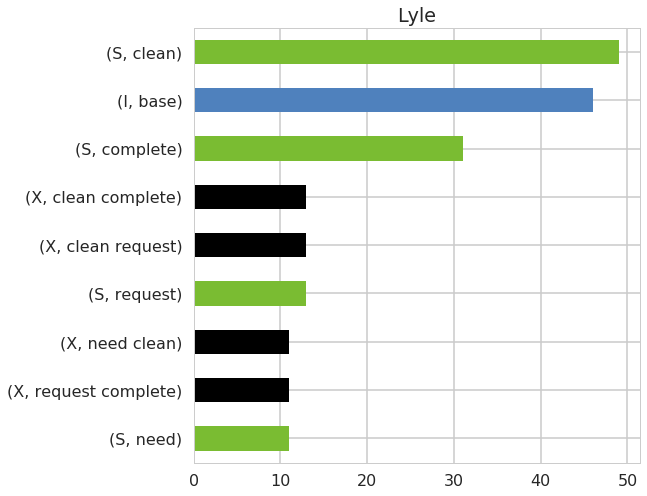

In [80]:
df['Description'][df['Tech Full Name'].str.contains('Lyle Cookson').fillna(False)]

def person_tags(name, n_reps):
    isguy = df['Tech Full Name'].str.contains(name).fillna(False)
    return tag_df.loc[isguy,(tag_df.loc[isguy,:].sum()>n_reps).values]

lyle_tags, steve_tags, andrew_tags = (person_tags('Lyle Cookson', 5),
                                      person_tags('Steve Andreozzi', 20),
                                      person_tags('Anthony Paolillo', 10))

# Glyle, *_ = tag_df_network(lyle_tags)
# Gsteve, *_ = tag_df_network(steve_tags)
# Gandrew, *_ = tag_df_network(andrew_tags)
mach_df = person_tags('Lyle Cookson',  5).sum().sort_values()
# mach_df = mach_df[mach_df>=5]
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(8,8))
    mach_df.plot(kind='barh', color=[colors[i] for i in mach_df.index.get_level_values(0)])
    plt.title('Lyle')

Threshold to tags happening >=5x
- we can quickly gauge the number of Lyle's *total* "base cleanings" as 45-50 
- Say we want to compare with other, more "typical" technicians...

$\rightarrow$ *small problem*...

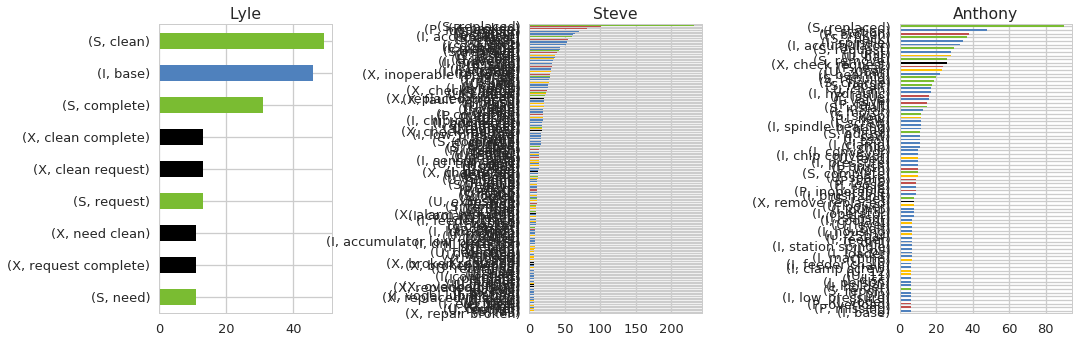

In [81]:
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('talk') as context:
    f, ax = plt.subplots(ncols=3, figsize=(15, 5))
    thres = [5, 20, 10]
    for n, mach in enumerate(['Lyle Cookson', 'Steve Andreozzi', 'Anthony Paolillo']):
        mach_df = person_tags(mach,  5).sum().sort_values()
#         mach_df = mach_df[mach_df>=5]
        mach_df.plot(kind='barh', color=[colors[i] for i in mach_df.index.get_level_values(0)], ax=ax[n])
        ax[n].set_title(mach.split(' ')[0])
    plt.tight_layout()

In [82]:
%%output size=200
%%opts Graph (edge_line_width=4 node_line_color='white', node_size=1)
%%opts EdgePaths [color_index='weight'] (line_width=1, cmap='viridis', color='dodgerblue', alpha=.2)
%%opts Overlay [width=300 legend_position='top_right'] Layout [tabs=True]
%%opts Nodes (size='size' line_color='white')
padding = dict(x=(-0.05, 1.05), y=(-0.05, 1.05))


kws = {'layout':nx.drawing.spring_layout, 
#        'layout_kws':{'prog':'neatopusher'} 
       'padding':dict(x=(-0.05, 1.05), y=(-0.05, 1.05))
      }
layout = hv.Layout([hv_net(person_tags('Lyle Cookson', 1), name='Lyle',**kws),
                    hv_net(person_tags('Steve Andreozzi', 20), name='Steve',**kws),
                    hv_net(person_tags('Anthony Paolillo', 10), name='Anthony',**kws),
                    hv_net(person_tags("Norm Neveux", 1), name='Norm',**kws),
                    hv_net(person_tags("Doug Patrick", 1), name='Doug',**kws),
                    hv_net(person_tags("Colin Doherty", 5), name='Colin',**kws)
                   ])#.cols(1)
# print(layout)
layout
# graph.edgepaths*graph.nodes

:Layout
   .Lyle.I    :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .Lyle.I      :Nodes   [x,y,index]   (count,size,NE)
      .Lyle.S      :Nodes   [x,y,index]   (count,size,NE)
      .Lyle.X      :Nodes   [x,y,index]   (count,size,NE)
      .Lyle.U      :Nodes   [x,y,index]   (count,size,NE)
      .Lyle.P      :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
      .Text.XV     :Text   [x,y]
      .Text.XVI    :Text   [x,y]
      .Text.XVII   :Text   [x,y]
      .Text.XVIII  :Text   [x,y]
      .Text.XIX    :Text   [x,y]
      .Text.XX     :Text   [x,y]
      .Text.XXI    :Text   [x,y]
      .Text.XXII   :Text   [x,y]
      .Text.XXIII  :Text   [x,y]
      .Text.XXIV   :Text   [x,y]
      .Text.XXV    :Text   [x,y]
      .Text.XXVI   :Text   [x,y]
      .Text.XXVII  :Text   [x,y]
   .Steve.I   :Overlay
      .EdgePaths.I  :EdgePaths   [x,y]
      .Steve.U      :Nodes   [x,y,index]   (count,size,NE)
      .Steve.I      :Nodes   [x,y,index]   (count,size,NE)
      .Steve.S      :Nodes   [x,y,index]   (count,size,NE)
      .Steve.P      :Nodes   [x,y,index]   (count,size,NE)
      .Steve.X      :Nodes   [x,y,index]   (count,size,NE)
      .Text.I       :Text   [x,y]
      .Text.II      :Text   [x,y]
      .Text.III     :Text   [x,y]
      .Text.IV      :Text   [x,y]
      .Text.V       :Text   [x,y]
      .Text.VI      :Text   [x,y]
      .Text.VII     :Text   [x,y]
      .Text.VIII    :Text   [x,y]
      .Text.IX      :Text   [x,y]
      .Text.X       :Text   [x,y]
      .Text.XI      :Text   [x,y]
      .Text.XII     :Text   [x,y]
      .Text.XIII    :Text   [x,y]
      .Text.XIV     :Text   [x,y]
      .Text.XV      :Text   [x,y]
      .Text.XVI     :Text   [x,y]
      .Text.XVII    :Text   [x,y]
      .Text.XVIII   :Text   [x,y]
      .Text.XIX     :Text   [x,y]
      .Text.XX      :Text   [x,y]
      .Text.XXI     :Text   [x,y]
      .Text.XXII    :Text   [x,y]
      .Text.XXIII   :Text   [x,y]
      .Text.XXIV    :Text   [x,y]
      .Text.XXV     :Text   [x,y]
      .Text.XXVI    :Text   [x,y]
      .Text.XXVII   :Text   [x,y]
      .Text.XXVIII  :Text   [x,y]
      .Text.XXIX    :Text   [x,y]
      .Text.XXX     :Text   [x,y]
      .Text.XXXI    :Text   [x,y]
      .Text.XXXII   :Text   [x,y]
      .Text.XXXIII  :Text   [x,y]
      .Text.XXXIV   :Text   [x,y]
      .Text.XXXV    :Text   [x,y]
      .Text.XXXVI   :Text   [x,y]
      .Text.XXXVII  :Text   [x,y]
      .Text.XXXVIII :Text   [x,y]
      .Text.XXXIX   :Text   [x,y]
      .Text.XL      :Text   [x,y]
      .Text.XLI     :Text   [x,y]
      .Text.XLII    :Text   [x,y]
      .Text.XLIII   :Text   [x,y]
      .Text.XLIV    :Text   [x,y]
      .Text.XLV     :Text   [x,y]
      .Text.XLVI    :Text   [x,y]
      .Text.XLVII   :Text   [x,y]
   .Anthony.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .Anthony.U   :Nodes   [x,y,index]   (count,size,NE)
      .Anthony.I   :Nodes   [x,y,index]   (count,size,NE)
      .Anthony.S   :Nodes   [x,y,index]   (count,size,NE)
      .Anthony.P   :Nodes   [x,y,index]   (count,size,NE)
      .Anthony.X   :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV

#### Machines Pt. II

In [83]:
%%output size=200
%%opts Text (text_align='r')
%%opts Graph (edge_line_width=4 node_line_color='white', node_size=1)
%%opts EdgePaths [color_index='weight'] (line_width=1, cmap='viridis', color='dodgerblue', alpha=.2)
%%opts Overlay [width=300 legend_position='top_right'] Layout [tabs=True]
%%opts Nodes (size='size' line_color='white')
# padding = dict(x=(-0.05, 1.05), y=(-0.05, 1.05))


kws = {'layout':nx.drawing.spring_layout,
#        'layout_kws':{'prog':'neato'} 
       'padding':dict(x=(-0.05, 1.05), y=(-0.05, 1.05))
      }

layout = hv.Layout([hv_net(machine_tags("H34",  5), name='H34',**kws),
                    hv_net(machine_tags("I19",  5), name='I19',**kws),
                    hv_net(machine_tags("H14",  5), name='H14',**kws)
                   ])
layout

:Layout
   .H34.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .H34.U       :Nodes   [x,y,index]   (count,size,NE)
      .H34.P       :Nodes   [x,y,index]   (count,size,NE)
      .H34.I       :Nodes   [x,y,index]   (count,size,NE)
      .H34.S       :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
   .I19.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .I19.P       :Nodes   [x,y,index]   (count,size,NE)
      .I19.U       :Nodes   [x,y,index]   (count,size,NE)
      .I19.I       :Nodes   [x,y,index]   (count,size,NE)
      .I19.S       :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
   .H14.I :Overlay
      .EdgePaths.I :EdgePaths   [x,y]
      .H14.U       :Nodes   [x,y,index]   (count,size,NE)
      .H14.I       :Nodes   [x,y,index]   (count,size,NE)
      .H14.S       :Nodes   [x,y,index]   (count,size,NE)
      .H14.P       :Nodes   [x,y,index]   (count,size,NE)
      .H14.X       :Nodes   [x,y,index]   (count,size,NE)
      .Text.I      :Text   [x,y]
      .Text.II     :Text   [x,y]
      .Text.III    :Text   [x,y]
      .Text.IV     :Text   [x,y]
      .Text.V      :Text   [x,y]
      .Text.VI     :Text   [x,y]
      .Text.VII    :Text   [x,y]
      .Text.VIII   :Text   [x,y]
      .Text.IX     :Text   [x,y]
      .Text.X      :Text   [x,y]
      .Text.XI     :Text   [x,y]
      .Text.XII    :Text   [x,y]
      .Text.XIII   :Text   [x,y]
      .Text.XIV    :Text   [x,y]
      .Text.XV     :Text   [x,y]
      .Text.XVI    :Text   [x,y]
      .Text.XVII   :Text   [x,y]
      .Text.XVIII  :Text   [x,y]
      .Text.XIX    :Text   [x,y]
      .Text.XX     :Text   [x,y]
      .Text.XXI    :Text   [x,y]
      .Text.XXII   :Text   [x,y]
      .Text.XXIII  :Text   [x,y]
      .Text.XXIV   :Text   [x,y]
      .Text.XXV    :Text   [x,y]

## Hierarchical Relationships

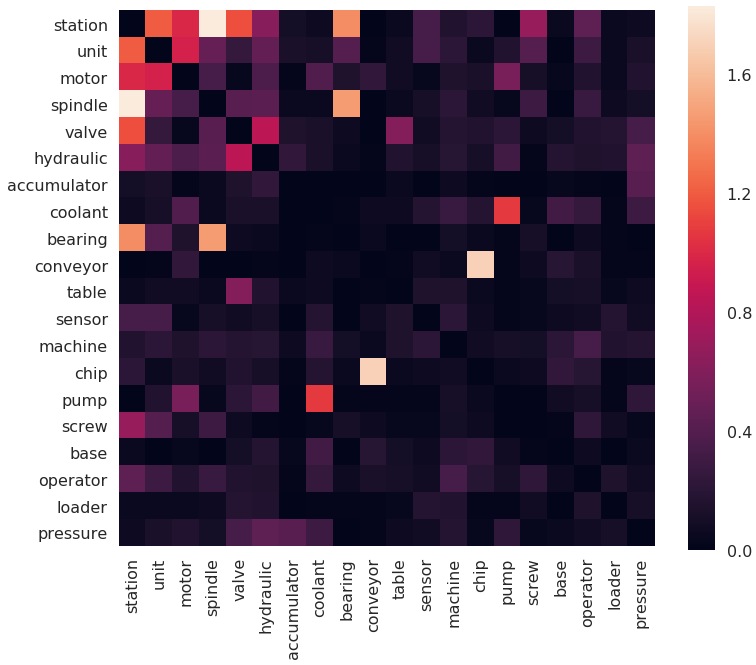

In [15]:
tag_similarity = mlp.tree.node_adj_mat(tag_df["I"])

with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.heatmap(200*tag_similarity.iloc[:20,:20], square=True)


In [16]:
D = mlp.tree.heymann_taxonomy(tag_similarity, dynamic=False, verbose=True, tau=6e-4);


 24%|██▍       | 160/667 [00:00<00:00, 789.92it/s] 

station


100%|██████████| 667/667 [00:02<00:00, 246.29it/s]

station
['plate', 'module', 'steve', 'piston', 'tube', 'stroke', 'slide', 'hub', 'relay', 'box', 'nut', 'plc', 'cover', 'inventory', 'bracket', 'intake', 'rotator', 'safety', 'replacement', 'scraper', 'key', 'air tool', 'tool oil', 'basket', 'counter', 'spindle valve', 'servo', 'collector', 'unit bearing', 'unit shelf', 'st_2 pressure', 'motor connector', 'lubrication tank', 'head bearing', 'panel', 'holder clamp', 'position sensor', 'machine index', 'laser tool', 'selector', 'encoder cable', 'filter tank', 'coolant pressure', 'station cross', 'clamp pressure', 'disc clutch', 'inventory unit', 'drill unit', 'screw tool', 'pulley belt', 'motor cable', 'guide channel', 'belt pulley', 'screen', 'loader valve', 'gate', 'unit belt', 'pulley hub', 'air hose', 'connector cable', 'station cross_drill', 'pin saw', 'wheel spindle', 'operator lead', 'tank operator', 'head unit', 'index prox', 'pressure coolant', 'motor fan', 'index speed', 'wire electrical', 'st_2 prox', 'chamfer unit', 'screw sh

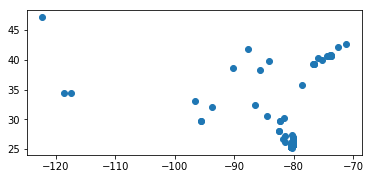

In [66]:
import geopandas as gpd
import requests
data = requests.get('https://opendata.miamidade.gov/resource/k7xd-qgzt.json')
gdf = gpd.GeoDataFrame(data.json())
gdf.head()



from shapely.geometry import Point, Polygon
# [Point(i) for i in gdf.location_1]
gdf = gdf.dropna(subset=['location_1'])
points=[Point(i['coordinates'][0], i['coordinates'][1]) for i in gdf.location_1]
gdf['geometry'] = points


gdf.plot()

In [126]:
crime_df = pd.DataFrame(data.json()).dropna(subset=['bookdate'])
crime_df = crime_df.set_index(pd.to_datetime(crime_df['bookdate']))
crime_df.sort_index(inplace=True)

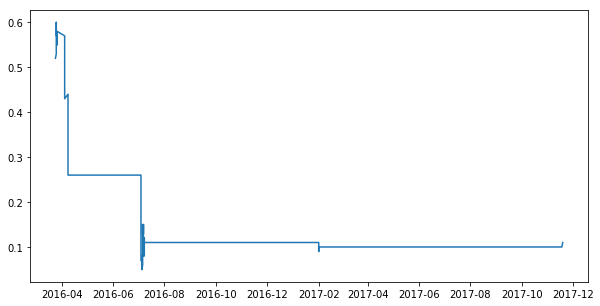

In [141]:
crime_df['is_homeless'] = crime_df.location_1_address=='HOMELESS'
plt.figure(figsize=(10,5))
plt.plot(crime_df.is_homeless.rolling(100).mean())


191



/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


3
2
3
3


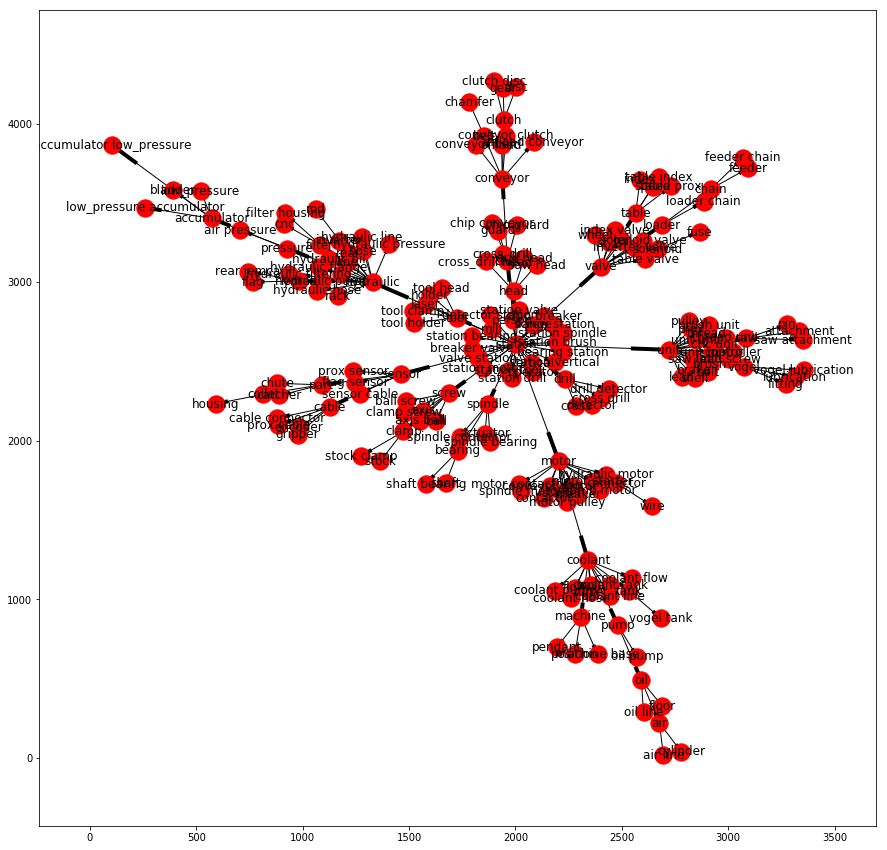

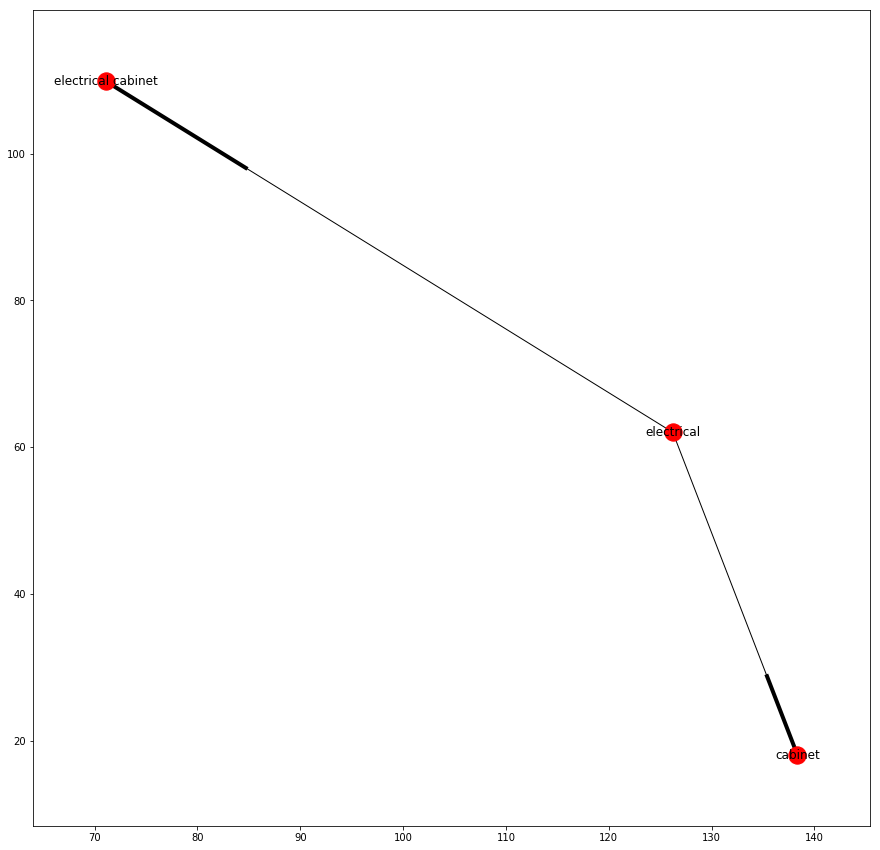

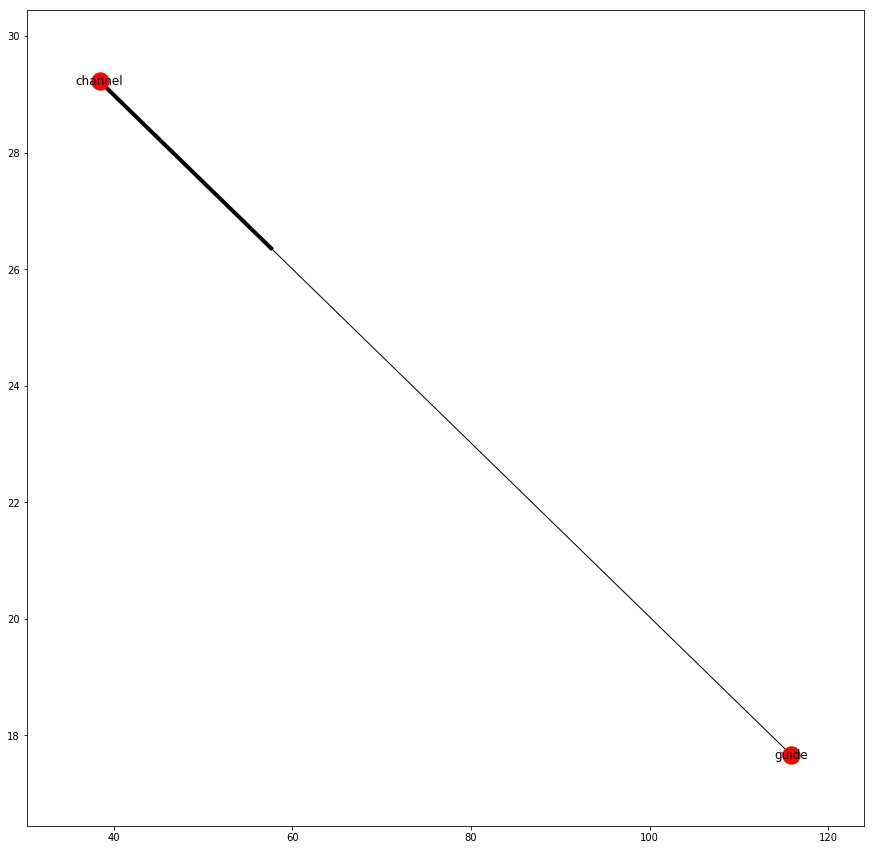

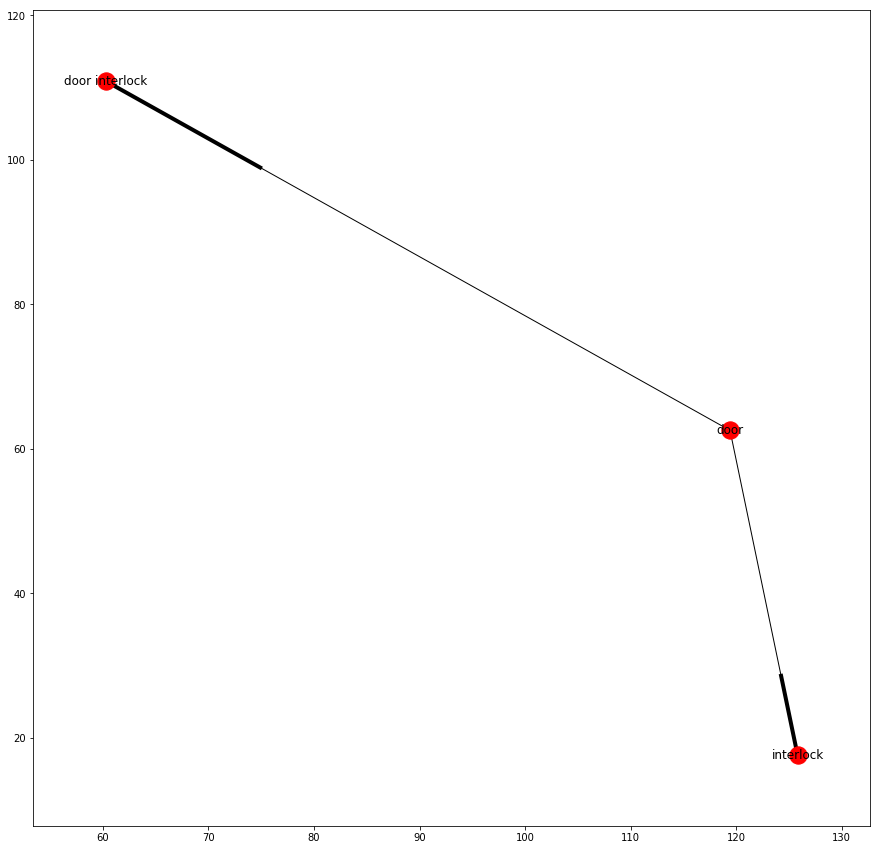

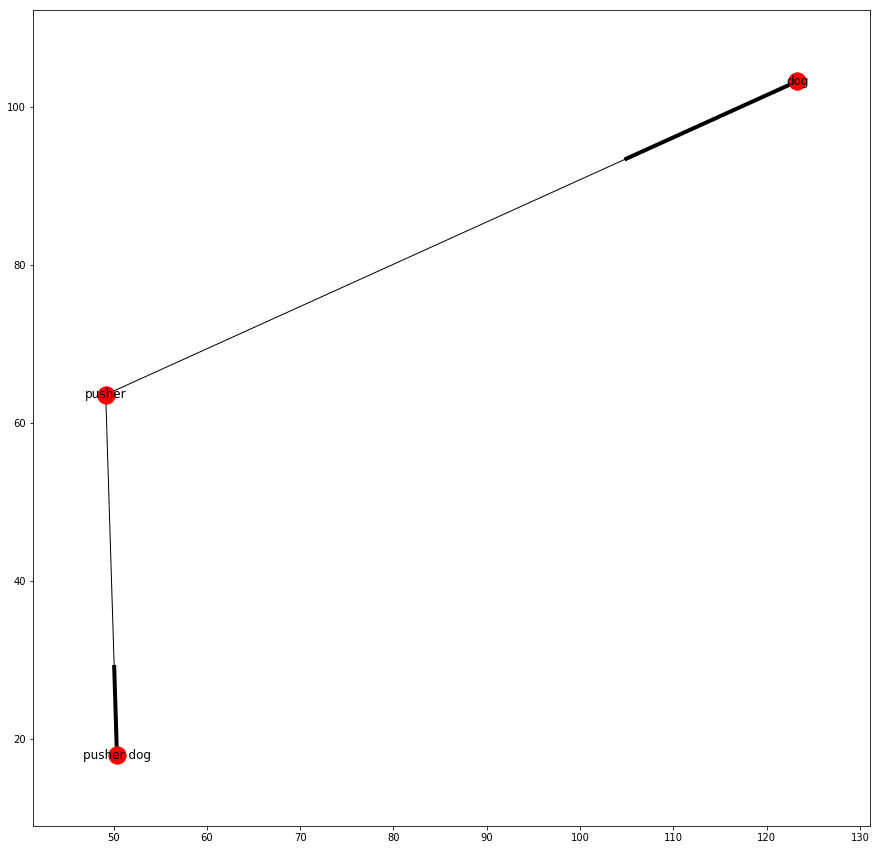

In [17]:
for n, d in enumerate(nx.weakly_connected_component_subgraphs(D)):
    print(nx.number_of_nodes(d))
    plt.figure(figsize=(15,15))
    nx.draw_networkx(d, pos=nx.drawing.nx_pydot.pydot_layout(d, prog='fdp'))

In [115]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'station')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'station'), outfile)

In [116]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1400 - margin.right - margin.left,
    height = 900 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [117]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [118]:
f2(w=1500,h=1200)

In [32]:
# thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
# substr = sorted(thes_dict, key=len, reverse=True)
# # matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# # matcher = lambda s: re.escape(s)
# rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
# clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
# clean_text.compute()[:4]
# TfidfVectorizer()
# '(?u)\\b\\w\\w+\\b'
clean_text = token_to_alias(raw_text, vocab)
clean_text.head()

0                       broken bar feeder chain repair
1    no power replace pin in pendant and powered ma...
2    smartscope harness broken part order   tech re...
3                  check   charge accumulator where ok
4    hydraulic leak at saw attachment replace seal ...
dtype: object

In [30]:

from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)
voc2 = tex2.annotation_assistant(data_dir/'2g_mine_vocab_test.csv')

['hydraulic leak' 'brush unit' 'accumulator check' ... 'production point'
 'place lowered' 'place lower']
attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


In [31]:
# NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}
NE_map_rules = {}
NE_types = 'IPSUX'
NE_map_rules['I I'] = 'I'
NE_map_rules['S I'] = 'S I'
NE_map_rules['P I'] = 'P I'

NE_map_rules['I S'] = 'S I'
NE_map_rules['I P'] = 'P I'

NE_map_rules['S S'] = 'X'
NE_map_rules['P P'] = 'X'
NE_map_rules['S P'] = 'X'
NE_map_rules['P S'] = 'X'
voc2 = ngram_automatch(vocab, voc2, NE_types, NE_map_rules)

# NE_map['']
# voc2['NE'] = voc2.NE.apply(lambda x: NE_map[x])
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
# voc2['score'] = tex2.scores_
# voc2.NE
voc2

{'I I': 'I', 'I P': 'P I', 'I S': 'S I', 'I U': '', 'I X': '', 'P I': 'P I', 'P P': 'X', 'P S': 'X', 'P U': '', 'P X': '', 'S I': 'S I', 'S P': 'X', 'S S': 'X', 'S U': '', 'S X': '', 'U I': '', 'U P': '', 'U S': '', 'U U': '', 'U X': '', 'X I': '', 'X P': '', 'X S': '', 'X U': '', 'X X': ''}


NE  alias  notes     score
tokens                                             
hydraulic leak          P I    NaN    NaN  0.005001
brush unit                I    NaN    NaN  0.004833
accumulator check       S I    NaN    NaN  0.004690
chip conveyor             I    NaN    NaN  0.004634
inoperable replace        X    NaN    NaN  0.004176
check request             X    NaN    NaN  0.003685
replace broken            X    NaN    NaN  0.003677
table index               I    NaN    NaN  0.003121
broken replace            X    NaN    NaN  0.003032
base clean              S I    NaN    NaN  0.002997
operator level                 NaN    NaN  0.002838
fault replace             X    NaN    NaN  0.002831
conveyor jam            P I    NaN    NaN  0.002609
charge 30bar                   NaN    NaN  0.002537
bar loader                     NaN    NaN  0.002526
check charge              X    NaN    NaN  0.002371
coolant pump              I    NaN    NaN  0.002256
broken repair             X    NaN    NaN  0.002211
spindle bearing           I    NaN    NaN  0.002201
drill detector            I    NaN    NaN  0.002105
bar feeder                     NaN    NaN  0.002021
feeder chain              I    NaN    NaN  0.001941
coolant leak            P I    NaN    NaN  0.001938
remove replace            X    NaN    NaN  0.001925
station 10                     NaN    NaN  0.001870
leak replace              X    NaN    NaN  0.001863
replace motor           S I    NaN    NaN  0.001855
station 11                     NaN    NaN  0.001747
chain broken            P I    NaN    NaN  0.001728
station 12                     NaN    NaN  0.001724
...                     ...    ...    ...       ...
piece load                     NaN    NaN  0.000040
regulator adjust               NaN    NaN  0.000039
new frl                        NaN    NaN  0.000039
regulator replace              NaN    NaN  0.000039
present iemca                  NaN    NaN  0.000039
play measured                  NaN    NaN  0.000039
prevent roll                   NaN    NaN  0.000038
protection module              NaN    NaN  0.000038
properly prevent               NaN    NaN  0.000038
overload protection            NaN    NaN  0.000038
replace linear                 NaN    NaN  0.000038
properly dk                    NaN    NaN  0.000038
referrence properly            NaN    NaN  0.000038
online dk                      NaN    NaN  0.000038
referencing jc                 NaN    NaN  0.000037
programming parameters         NaN    NaN  0.000037
norm reloaded                  NaN    NaN  0.000037
reloaded data                  NaN    NaN  0.000037
place cylinder                 NaN    NaN  0.000037
remained person                NaN    NaN  0.000036
noise chattering               NaN    NaN  0.000036
phasing replace                NaN    NaN  0.000036
remained purchased             NaN    NaN  0.000036
prevent fault                  NaN    NaN  0.000035
plugged marcel                 NaN    NaN  0.000035
release sensor                 NaN    NaN  0.000033
point machine                  NaN    NaN  0.000033
production point               NaN    NaN  0.000033
place lowered                  NaN    NaN  0.000033
place lower                    NaN    NaN  0.000033

[5000 rows x 4 columns]

In [16]:
NE_dict = vocab.NE.fillna('U').to_dict()
NE_dict.update(vocab.fillna('U').reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)

# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


I       P                  S U
0                 chain, feeder  broken             repair  
1  machine, cable, pendant, pin   short            replace  
2                          part  broken      order, repair  
3                   accumulator          ok, charge, check  
4    attachment, saw, hydraulic    leak            replace

In [140]:
tag_df['og'] = raw_text
tag_df

I                    P  \
0                                      chain, feeder               broken   
1                       machine, cable, pendant, pin                short   
2                                               part               broken   
3                                        accumulator                        
4                         attachment, saw, hydraulic                 leak   
5                                       unit, thread                        
6         saw, gear, shelf, attachment, person, unit                        
7                                        accumulator                        
8                             mill, spindle, station                        
9                                    line, hydraulic        rupture, leak   
10                                      chip, turret                 leak   
11                                    spindle, index                        
12                                                                          
13                     drill, unit, hydraulic, cross                 leak   
14                                       accumulator                        
15                                          conveyor                  jam   
16                                  motor, hydraulic                alarm   
17                                                                   leak   
18                                     screw, loader                        
19                                              part                 drop   
20                         chip, belt, box, conveyor           inoperable   
21                                              pump           inoperable   
22         bearing, shelf, steve, unit, drill, cross               broken   
23                  cable, sensor, unit, brush, prox                stuck   
24                             unit, attachment, saw                short   
25                                    chip, conveyor           inoperable   
26                         head, unit, belt, chamfer               broken   
27                                 head, screw, tool               broken   
28                             unit, attachment, saw                short   
29             station, spindle, drill, belt, pulley                        
...                                              ...                  ...   
3405                                     unit, brush                  jam   
3406                           clamp, screw, station                strip   
3407                             unit, brush, pulley       failure, stuck   
3408                                person, inverter                        
3409                                           motor                alarm   
3410              brake, station, unit, motor, brush       failure, fault   
3411                       unit, brake, brush, motor              failure   
3412                             holder, unit, brush                        
3413        operator, key, person, actuator, gripper  failure, inoperable   
3414                                   wire, breaker  short, trip, unable   
3415             bolt, station, motor, screw, pulley                loose   
3416                low_pressure, valve, accumulator                 leak   
3417                                            bowl               broken   
3418                       low_pressure, accumulator                issue   
3419            pressure, coolant, hydraulic, collet                 leak   
3420                                   counter, part                        
3421  connector, cable, valve, rotator, coil, sensor               broken   
3422         detector, module, drill, pendant, screw    inoperable, loose   
3423                                  operator, axis                        
3424                                   spindle, part                issue   
3425                                         br

In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

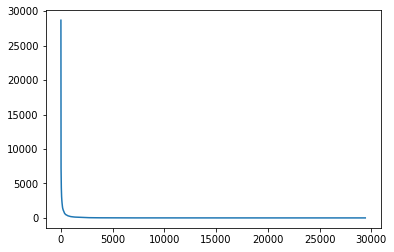

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

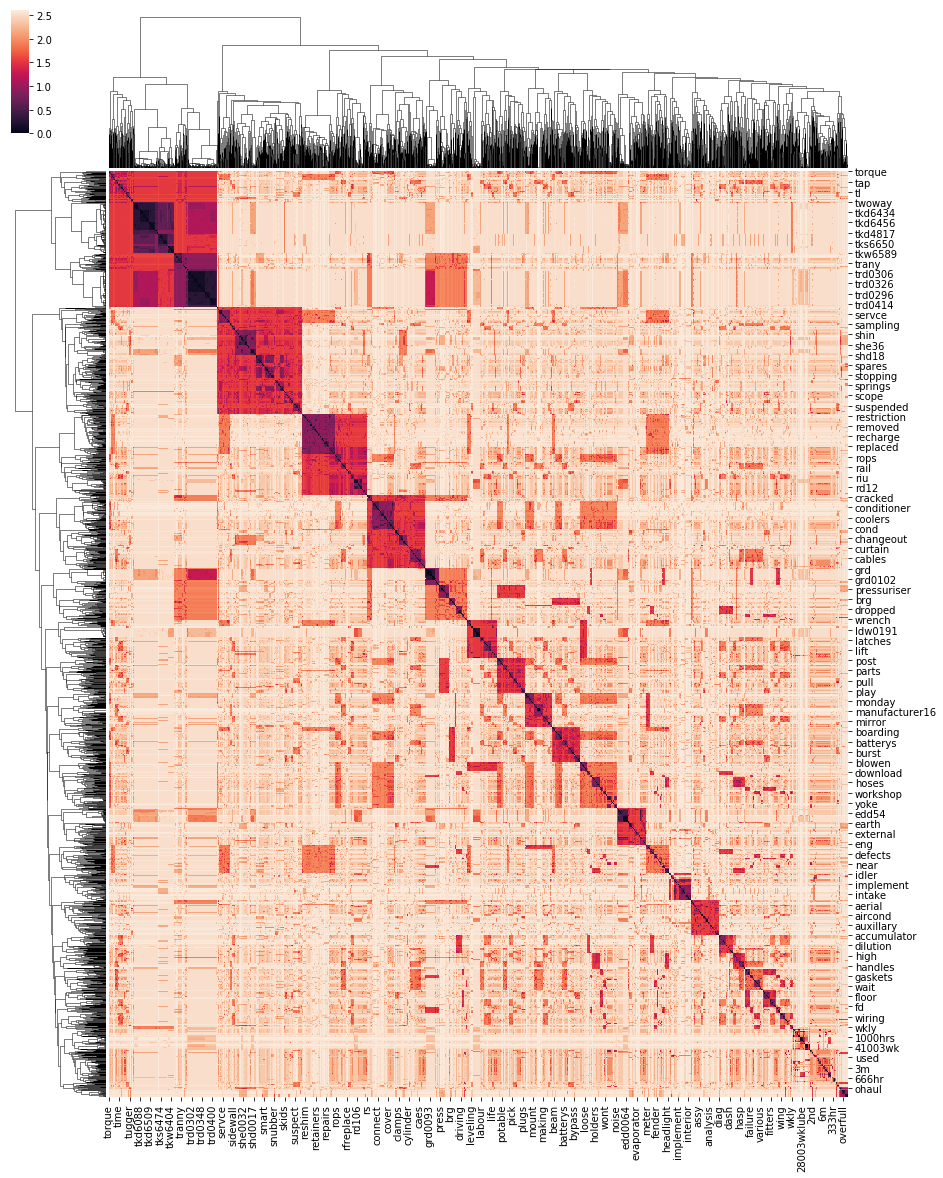

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()